# Churn Estimator
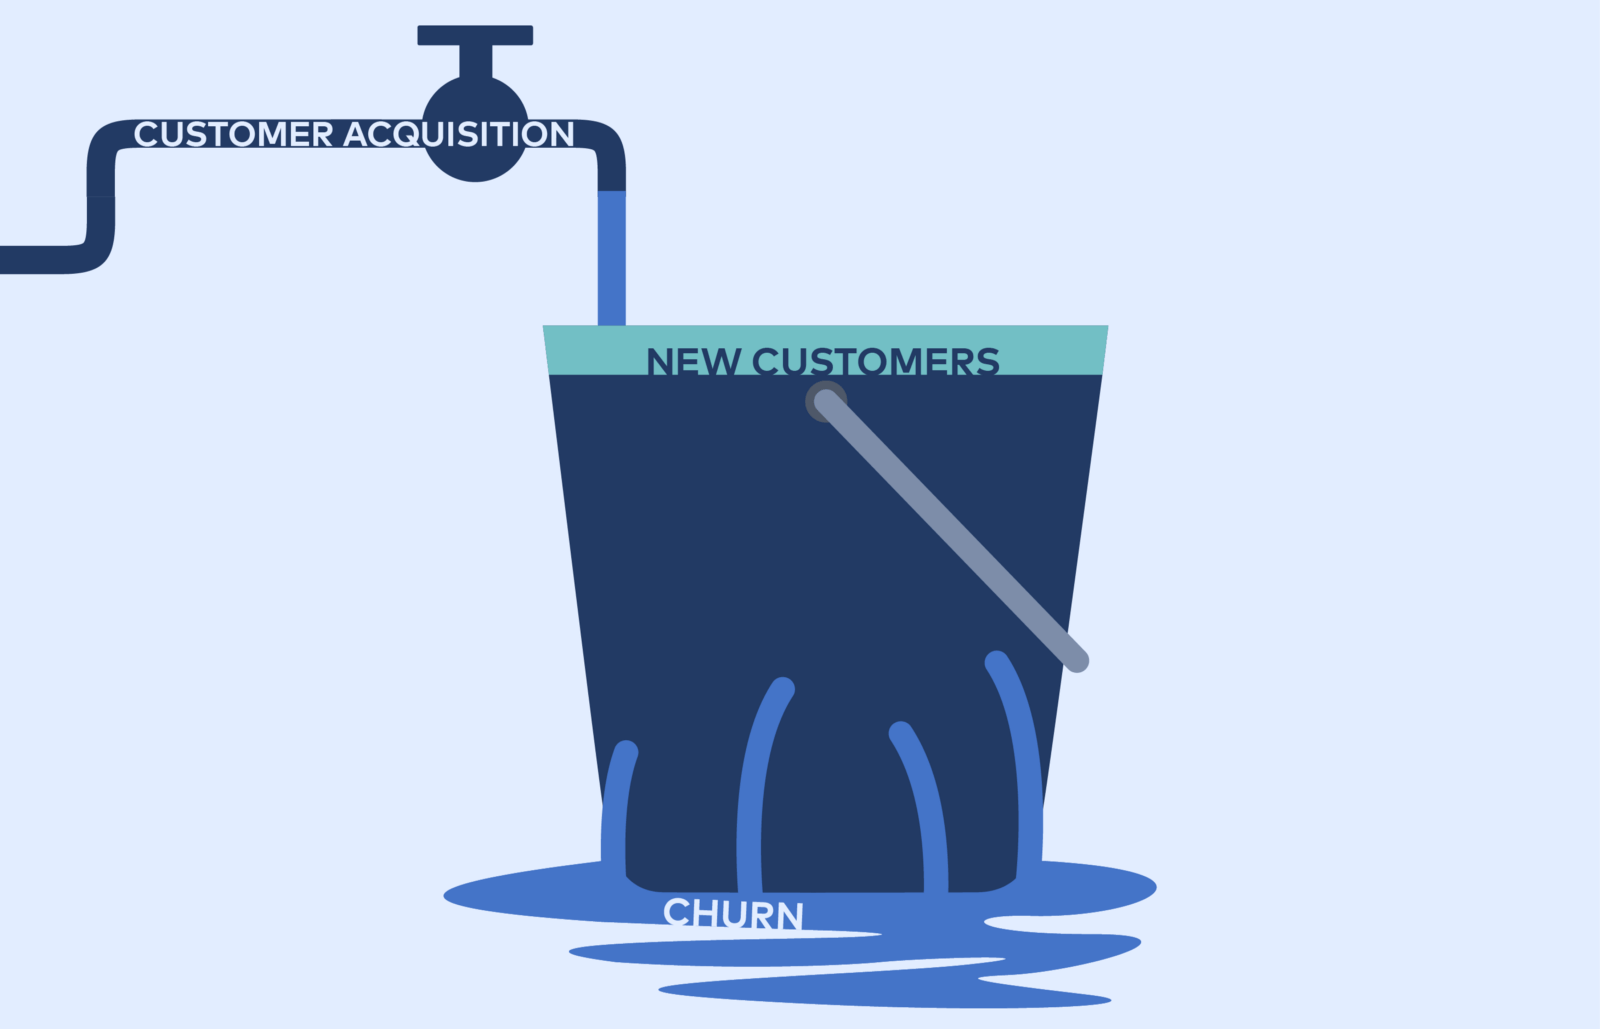

## Data Acquisition

In [2]:
# dowload data
!kaggle datasets download -d barun2104/telecom-churn

  0%|                                               | 0.00/45.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 45.5k/45.5k [00:00<00:00, 1.05MB/s]


In [3]:
# unzip it
!unzip telecom-churn.zip

Archive:  telecom-churn.zip
  inflating: telecom_churn.csv       


## Data Exploration

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pandas_profiling
import os
from sklearn.model_selection import train_test_split

# Column Description from source
https://www.kaggle.com/barun2104/telecom-churn

### Churn 
1 if customer cancelled service, 0 if not

### AccountWeeks
number of weeks customer has had active account

### ContractRenewal
1 if customer recently renewed contract, 0 if not

### DataPlan
1 if customer has data plan, 0 if not

### DataUsage
gigabytes of monthly data usage

### CustServCalls
number of calls into customer service

### DayMins
average daytime minutes per month

### DayCalls
average number of daytime calls

### MonthlyCharge
average monthly bill

### OverageFee
largest overage fee in last 12 months

In [2]:
csv_file = 'telecom_churn.csv'
churn_df = pd.read_csv(csv_file)

# print out the first few rows of data info
churn_df.head(10)

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0      0           128                1         1       2.70              1   
1      0           107                1         1       3.70              1   
2      0           137                1         0       0.00              0   
3      0            84                0         0       0.00              2   
4      0            75                0         0       0.00              3   
5      0           118                0         0       0.00              0   
6      0           121                1         1       2.03              3   
7      0           147                0         0       0.00              0   
8      0           117                1         0       0.19              1   
9      0           141                0         1       3.02              0   

   DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0    265.1       110           89.0        9.87      10.0  
1    161.6       123           82.0        9.78      13.7  
2    243.4       114           52.0        6.06      12.2  
3    299.4        71           57.0        3.10       6.6  
4    166.7       113           41.0        7.42      10.1  
5    223.4        98           57.0       11.03       6.3  
6    218.2        88           87.3       17.43       7.5  
7    157.0        79           36.0        5.16       7.1  
8    184.5        97           63.9       17.58       8.7  
9    258.6        84           93.2       11.10      11.2

In [3]:
# print out some stats about the data
print('Number of samples: ', churn_df.shape[0],' [Churns:',churn_df[churn_df['Churn']==1].shape[0],'(',int(churn_df[churn_df['Churn']==1].shape[0]/churn_df.shape[0]*100),'%) + Not Churns:',churn_df[churn_df['Churn']==0].shape[0],']') 

Number of samples:  3333  [Churns: 483 ( 14 %) + Not Churns: 2850 ]


In [4]:
pd.options.display.float_format = "{:,.2f}".format

churn_df.describe()

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
count 3,333.00      3,333.00         3,333.00  3,333.00   3,333.00   
mean      0.14        101.06             0.90      0.28       0.82   
std       0.35         39.82             0.30      0.45       1.27   
min       0.00          1.00             0.00      0.00       0.00   
25%       0.00         74.00             1.00      0.00       0.00   
50%       0.00        101.00             1.00      0.00       0.00   
75%       0.00        127.00             1.00      1.00       1.78   
max       1.00        243.00             1.00      1.00       5.40   

       CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
count       3,333.00 3,333.00  3,333.00       3,333.00    3,333.00  3,333.00  
mean            1.56   179.78    100.44          56.31       10.05     10.24  
std             1.32    54.47     20.07          16.43        2.54      2.79  
min             0.00     0.00      0.00          14.00        0.00      0.00  
25%             1.00   143.70     87.00          45.00        8.33      8.50  
50%             1.00   179.40    101.00          53.50       10.07     10.30  
75%             2.00   216.40    114.00          66.20       11.77     12.10  
max             9.00   350.80    165.00         111.30       18.19     20.00

In [5]:
churn_df.profile_report()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Let's take a look at the correlation matrix in more details

In [6]:
# Create correlation matrix for just Features to determine different models to test
corr_matrix = churn_df.corr().abs().round(2)

# display shows all of a dataframe
display(corr_matrix)

Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
Churn             1.00          0.02             0.26      0.10       0.09   
AccountWeeks      0.02          1.00             0.02      0.00       0.01   
ContractRenewal   0.26          0.02             1.00      0.01       0.02   
DataPlan          0.10          0.00             0.01      1.00       0.95   
DataUsage         0.09          0.01             0.02      0.95       1.00   
CustServCalls     0.21          0.00             0.02      0.02       0.02   
DayMins           0.21          0.01             0.05      0.00       0.00   
DayCalls          0.02          0.04             0.00      0.01       0.01   
MonthlyCharge     0.07          0.01             0.05      0.74       0.78   
OverageFee        0.09          0.01             0.02      0.02       0.02   
RoamMins          0.07          0.01             0.05      0.00       0.16   

                 CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  \
Churn                     0.21     0.21      0.02           0.07        0.09   
AccountWeeks              0.00     0.01      0.04           0.01        0.01   
ContractRenewal           0.02     0.05      0.00           0.05        0.02   
DataPlan                  0.02     0.00      0.01           0.74        0.02   
DataUsage                 0.02     0.00      0.01           0.78        0.02   
CustServCalls             1.00     0.01      0.02           0.03        0.01   
DayMins                   0.01     1.00      0.01           0.57        0.01   
DayCalls                  0.02     0.01      1.00           0.01        0.02   
MonthlyCharge             0.03     0.57      0.01           1.00        0.28   
OverageFee                0.01     0.01      0.02           0.28        1.00   
RoamMins                  0.01     0.01      0.02           0.12        0.01   

                 RoamMins  
Churn                0.07  
AccountWeeks         0.01  
ContractRenewal      0.05  
DataPlan             0.00  
DataUsage            0.16  
CustServCalls        0.01  
DayMins              0.01  
DayCalls             0.02  
MonthlyCharge        0.12  
OverageFee           0.01  
RoamMins             1.00

We can see that DataPlan and DataUsage share a **95%** correlation and since DataUsage is richer in data we will drop DataUsage and drop DataPlan for this analysis

In [7]:
churn_decorr_df=churn_df.drop('DataPlan', axis=1)
churn_decorr_df.head(10)

Churn  AccountWeeks  ContractRenewal  DataUsage  CustServCalls  DayMins  \
0      0           128                1       2.70              1   265.10   
1      0           107                1       3.70              1   161.60   
2      0           137                1       0.00              0   243.40   
3      0            84                0       0.00              2   299.40   
4      0            75                0       0.00              3   166.70   
5      0           118                0       0.00              0   223.40   
6      0           121                1       2.03              3   218.20   
7      0           147                0       0.00              0   157.00   
8      0           117                1       0.19              1   184.50   
9      0           141                0       3.02              0   258.60   

   DayCalls  MonthlyCharge  OverageFee  RoamMins  
0       110          89.00        9.87     10.00  
1       123          82.00        9.78     13.70  
2       114          52.00        6.06     12.20  
3        71          57.00        3.10      6.60  
4       113          41.00        7.42     10.10  
5        98          57.00       11.03      6.30  
6        88          87.30       17.43      7.50  
7        79          36.00        5.16      7.10  
8        97          63.90       17.58      8.70  
9        84          93.20       11.10     11.20

Sample and Split the data for training and validation

In [8]:
x=churn_decorr_df.drop('Churn', axis=1)
x.head(10)

AccountWeeks  ContractRenewal  DataUsage  CustServCalls  DayMins  DayCalls  \
0           128                1       2.70              1   265.10       110   
1           107                1       3.70              1   161.60       123   
2           137                1       0.00              0   243.40       114   
3            84                0       0.00              2   299.40        71   
4            75                0       0.00              3   166.70       113   
5           118                0       0.00              0   223.40        98   
6           121                1       2.03              3   218.20        88   
7           147                0       0.00              0   157.00        79   
8           117                1       0.19              1   184.50        97   
9           141                0       3.02              0   258.60        84   

   MonthlyCharge  OverageFee  RoamMins  
0          89.00        9.87     10.00  
1          82.00        9.78     13.70  
2          52.00        6.06     12.20  
3          57.00        3.10      6.60  
4          41.00        7.42     10.10  
5          57.00       11.03      6.30  
6          87.30       17.43      7.50  
7          36.00        5.16      7.10  
8          63.90       17.58      8.70  
9          93.20       11.10     11.20

In [9]:
y=churn_decorr_df[['Churn']]
y.head(10)

Churn
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0

In [10]:
# Creation of the data set for training, test and validation
x_train, x_not_train, y_train, y_not_train = train_test_split(x,y,test_size=0.4,random_state=21,stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_not_train,y_not_train,test_size=0.5,random_state=21,stratify=y_not_train)

In [11]:
print('Number of Train samples: ', x_train.shape[0],' [Churns:',y_train[y_train['Churn']==1].shape[0],'(',int(y_train[y_train['Churn']==1].shape[0]/y_train.shape[0]*100),'%) + Not Churns:',y_train[y_train['Churn']==0].shape[0],']')
print('Number of Validation samples: ', x_val.shape[0],' [Churns:',y_val[y_val['Churn']==1].shape[0],'(',int(y_val[y_val['Churn']==1].shape[0]/y_val.shape[0]*100),'%) + Not Churns:',y_val[y_val['Churn']==0].shape[0],']')
print('Number of Test samples: ', x_test.shape[0],' [Churns:',y_test[y_test['Churn']==1].shape[0],'(',int(y_test[y_test['Churn']==1].shape[0]/y_test.shape[0]*100),'%) + Not Churns:',y_test[y_test['Churn']==0].shape[0],']')

Number of Train samples:  1999  [Churns: 290 ( 14 %) + Not Churns: 1709 ]
Number of Validation samples:  667  [Churns: 97 ( 14 %) + Not Churns: 570 ]
Number of Test samples:  667  [Churns: 96 ( 14 %) + Not Churns: 571 ]


## File Creation in csv

In [12]:
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    data=pd.concat([pd.DataFrame(y),pd.DataFrame(x)],axis=1)
    
    key=os.path.join(data_dir,filename)
    
    data.to_csv(key, header=False, index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [49]:
# directory to save the data
data_dir = 'churn_data'

make_csv(x_train, y_train, filename='train.csv', data_dir=data_dir)
# make_csv(x_test, y_test, filename='test.csv', data_dir=data_dir)
make_csv(x_val, y_val, filename='validation.csv', data_dir=data_dir)
# pd.DataFrame(x_val).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.DataFrame(x_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

Path created: churn_data/train.csv
Path created: churn_data/validation.csv


## Load File to S3

In [25]:
import pandas as pd
import boto3
import sagemaker
import numpy as np

In [41]:
# session and role
session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = session.default_bucket()

In [50]:
# should be the name of directory you created to save your features data
data_dir = 'churn_data'

# set prefix, a descriptive name for a directory  
prefix = 'Project_churn_predictor'

# upload all data to S3
#input_data = session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
print(test_location)
print(val_location)
print(train_location)

s3://sagemaker-us-east-1-701904821656/Project_churn_predictor/test.csv
s3://sagemaker-us-east-1-701904821656/Project_churn_predictor/validation.csv
s3://sagemaker-us-east-1-701904821656/Project_churn_predictor/train.csv


## Modeling

In [43]:
from sagemaker import get_execution_role, image_uris
from sklearn.metrics import accuracy_score

In [44]:
# Our current execution role is require when creating the model as the training
# and inference code will need to access the model artifacts.
role = get_execution_role()

In [45]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.

container = image_uris.retrieve("xgboost", session.boto_region_name, version="latest")

In [51]:
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)


xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

In [52]:
s3_input_train = sagemaker.TrainingInput(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data=val_location, content_type='csv')

In [53]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-05-29 20:20:53 Starting - Starting the training job...
2021-05-29 20:21:17 Starting - Launching requested ML instancesProfilerReport-1622319653: InProgress
.........
2021-05-29 20:22:39 Starting - Preparing the instances for training......
2021-05-29 20:23:53 Downloading - Downloading input data...
2021-05-29 20:24:18 Training - Downloading the training image..Arguments: train
[2021-05-29:20:24:31:INFO] Running standalone xgboost training.
[2021-05-29:20:24:31:INFO] File size need to be processed in the node: 0.1mb. Available memory size in the node: 8402.37mb
[2021-05-29:20:24:31:INFO] Determined delimiter of CSV input is ','
[20:24:31] S3DistributionType set as FullyReplicated
[20:24:31] 1999x9 matrix with 17991 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-29:20:24:31:INFO] Determined delimiter of CSV input is ','
[20:24:31] S3DistributionType set as FullyReplicated
[20:24:31] 667x9 matrix with 6003 entries loaded from /opt/ml/input

In [54]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [55]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

...........................
Arguments: serve
[2021-05-29 20:29:46 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-29 20:29:46 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-29 20:29:46 +0000] [1] [INFO] Using worker: gevent
[2021-05-29 20:29:46 +0000] [20] [INFO] Booting worker with pid: 20
[2021-05-29 20:29:46 +0000] [21] [INFO] Booting worker with pid: 21
[2021-05-29 20:29:46 +0000] [22] [INFO] Booting worker with pid: 22
[2021-05-29 20:29:46 +0000] [23] [INFO] Booting worker with pid: 23
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 

In [56]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-701904821656/xgboost-2021-05-29-20-25-23-010/test.csv.out to churn_data/test.csv.out


In [57]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [58]:
accuracy_score(y_val, predictions)

0.7766116941529235

## Evaluation

In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
#confusion matrix for XGBoost
confusion = confusion_matrix(y_val, predictions)
print("confusion matrix with XGBoost:\n{}".format(confusion))

confusion matrix with XGBoost:
[[508  62]
 [ 87  10]]


In [62]:
print("Accuracy: {:.2f}".format((confusion[0][0]+confusion[1][1])/sum(sum(confusion))))
print("Precision: {:.2f}".format(confusion[1][1]/sum(np.transpose(confusion)[1])))
print("Recall: {:.2f}".format(confusion[1][1]/sum(confusion[1])))

Accuracy: 0.78
Precision: 0.14
Recall: 0.10


## Tunning

In [72]:
xgb_tunned = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    instance_count=1,                  # How many compute instances
                                    instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
xgb_tunned.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric='auc',
                        scale_pos_weight=6,
                        early_stopping_rounds=10,
                        num_round=500)

In [73]:
xgb_tunned.fit({'train': s3_input_train, 'validation': s3_input_validation})

2021-05-29 20:51:52 Starting - Starting the training job...
2021-05-29 20:52:16 Starting - Launching requested ML instancesProfilerReport-1622321512: InProgress
......
2021-05-29 20:53:16 Starting - Preparing the instances for training......
2021-05-29 20:54:16 Downloading - Downloading input data...
2021-05-29 20:54:53 Training - Training image download completed. Training in progress.
2021-05-29 20:54:53 Uploading - Uploading generated training model.Arguments: train
[2021-05-29:20:54:48:INFO] Running standalone xgboost training.
[2021-05-29:20:54:48:INFO] File size need to be processed in the node: 0.1mb. Available memory size in the node: 8407.77mb
[2021-05-29:20:54:48:INFO] Determined delimiter of CSV input is ','
[20:54:48] S3DistributionType set as FullyReplicated
[20:54:48] 1999x9 matrix with 17991 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-05-29:20:54:48:INFO] Determined delimiter of CSV input is ','
[20:54:48] S3DistributionType s

In [78]:
xgb_tunned_transformer = xgb_tunned.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [79]:
xgb_tunned_transformer.transform(test_location, content_type='text/csv', split_type='Line')

.......................................
.Arguments: serve
Arguments: serve
[2021-05-29 21:09:48 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-05-29 21:09:48 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-05-29 21:09:48 +0000] [1] [INFO] Using worker: gevent
[2021-05-29 21:09:48 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subprocess=True)
[2021-05-29:21:09:48:INFO] Model loaded successfully

In [80]:
!aws s3 cp --recursive $xgb_tunned_transformer.output_path $data_dir+'tunned'

download: s3://sagemaker-us-east-1-701904821656/xgboost-2021-05-29-21-03-23-174/test.csv.out to churn_data+tunned/test.csv.out


In [81]:
predictions_tunned = pd.read_csv(os.path.join(data_dir+'+tunned', 'test.csv.out'), header=None)
predictions_tunned = [round(num) for num in predictions_tunned.squeeze().values]

In [82]:
accuracy_score(y_val, predictions_tunned)

0.7211394302848576

In [70]:
#confusion matrix for XGBoost
confusion_tunned = confusion_matrix(y_val, predictions_tunned)
print("confusion matrix with XGBoost:\n{}".format(confusion_tunned))

confusion matrix with XGBoost:
[[459 111]
 [ 77  20]]


In [71]:
print("Accuracy: {:.2f}".format((confusion_tunned[0][0]+confusion_tunned[1][1])/sum(sum(confusion_tunned))))
print("Precision: {:.2f}".format(confusion_tunned[1][1]/sum(np.transpose(confusion_tunned)[1])))
print("Recall: {:.2f}".format(confusion_tunned[1][1]/sum(confusion_tunned[1])))

Accuracy: 0.72
Precision: 0.15
Recall: 0.21


### Linear Learner